# Check Bounding Boxex NIH

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
# from multiprocessing import Pool
import multiprocessing
import time
import random
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [2]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'?': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                '??': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [3]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [4]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [128]:
df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(196934, 9)
--- 159.72050404548645 seconds ---


In [129]:
df.to_csv('labels.csv', index = False)
df

?         cell     comment annotation_type  ??  \
0      1-1  Parasitized  No_Comment           Point   1   
1      1-2   Uninfected  No_Comment           Point   1   
2      1-3   Uninfected  No_Comment           Point   1   
3      1-4   Uninfected  No_Comment           Point   1   
4      1-5   Uninfected  No_Comment           Point   1   
..     ...          ...         ...             ...  ..   
166  4-167  Parasitized  No_comment         Polygon  25   
167  4-168  Parasitized  No_comment         Polygon  21   
168  4-169  Parasitized  No_comment         Polygon  20   
169  4-170  Parasitized  No_comment         Polygon  20   
170  4-171  Parasitized  No_comment         Polygon  17   

                                              position             filename  \
0                                       [(2470, 1302)]  IMG_20150918_161508   
1                                        [(1598, 944)]  IMG_20150918_161508   
2                                        [(1756, 987)]  IMG_20150918_161508   
3                                        [(2000, 895)]  IMG_20150918_161508   
4                                       [(1938, 1006)]  IMG_20150918_161508   
..                                                 ...                  ...   
166  [(2399, 383), (2404, 363), (2412, 351), (2426,...  IMG_20151004_131030   
167  [(3522, 2250), (3536, 2230), (3563, 2215), (35...  IMG_20151004_131030   
168  [(3321, 2138), (3335, 2114), (3347, 2103), (33...  IMG_20151004_131030   
169  [(3433, 1867), (3441, 1845), (3455, 1831), (34...  IMG_20151004_131030   
170  [(1432, 1762), (1438, 1739), (1456, 1719), (14...  IMG_20151004_131030   

                                              txt_path  \
0    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
..                                                 ...   
166  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
167  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
168  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
169  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
170  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                              img_path  
0    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4    ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
..                                                 ...  
166  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
167  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
168  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
169  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
170  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [130]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [131]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [132]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [200]:
filename =  'IMG_20150623_134547' #'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file

?         cell     comment annotation_type ??        position  \
0      2-1  Parasitized  No_Comment           Point  1  [(1131, 1205)]   
1      2-2   Uninfected  No_Comment           Point  1  [(3804, 1277)]   
2      2-3   Uninfected  No_Comment           Point  1  [(1898, 1277)]   
3      2-4   Uninfected  No_Comment           Point  1  [(1818, 1350)]   
4      2-5   Uninfected  No_Comment           Point  1  [(1828, 1481)]   
..     ...          ...         ...             ... ..             ...   
243  2-244   Uninfected  No_Comment           Point  1  [(2060, 1156)]   
244  2-245   Uninfected  No_Comment           Point  1  [(2046, 1363)]   
245  2-246   Uninfected  No_Comment           Point  1   [(1863, 451)]   
246  2-247   Uninfected  No_Comment           Point  1   [(1865, 602)]   
247  2-248   Uninfected  No_Comment           Point  1   [(1842, 804)]   

                filename                                           txt_path  \
0    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
1    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
2    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
3    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
4    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
..                   ...                                                ...   
243  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
244  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
245  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
246  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
247  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   

                                              img_path  
0    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
1    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
2    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
3    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
4    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
..                                                 ...  
243  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
244  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
245  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
246  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
247  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  

[248 rows x 9 columns]

In [202]:
df_file[df_file['position'].str.len() > 0]

?         cell     comment annotation_type ??        position  \
0      2-1  Parasitized  No_Comment           Point  1  [(1131, 1205)]   
1      2-2   Uninfected  No_Comment           Point  1  [(3804, 1277)]   
2      2-3   Uninfected  No_Comment           Point  1  [(1898, 1277)]   
3      2-4   Uninfected  No_Comment           Point  1  [(1818, 1350)]   
4      2-5   Uninfected  No_Comment           Point  1  [(1828, 1481)]   
..     ...          ...         ...             ... ..             ...   
243  2-244   Uninfected  No_Comment           Point  1  [(2060, 1156)]   
244  2-245   Uninfected  No_Comment           Point  1  [(2046, 1363)]   
245  2-246   Uninfected  No_Comment           Point  1   [(1863, 451)]   
246  2-247   Uninfected  No_Comment           Point  1   [(1865, 602)]   
247  2-248   Uninfected  No_Comment           Point  1   [(1842, 804)]   

                filename                                           txt_path  \
0    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
1    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
2    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
3    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
4    IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
..                   ...                                                ...   
243  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
244  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
245  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
246  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
247  IMG_20150623_134547  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   

                                              img_path  
0    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
1    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
2    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
3    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
4    ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
..                                                 ...  
243  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
244  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
245  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
246  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
247  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  

[248 rows x 9 columns]

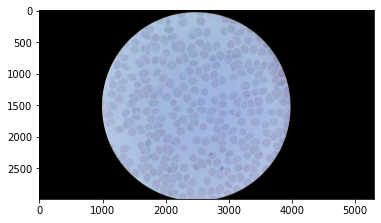

In [194]:
img = cv2.imread(df_file['img_path'][0], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

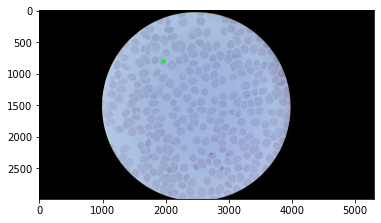

In [196]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

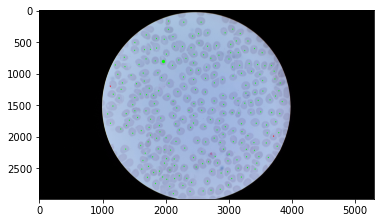

In [197]:
#fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

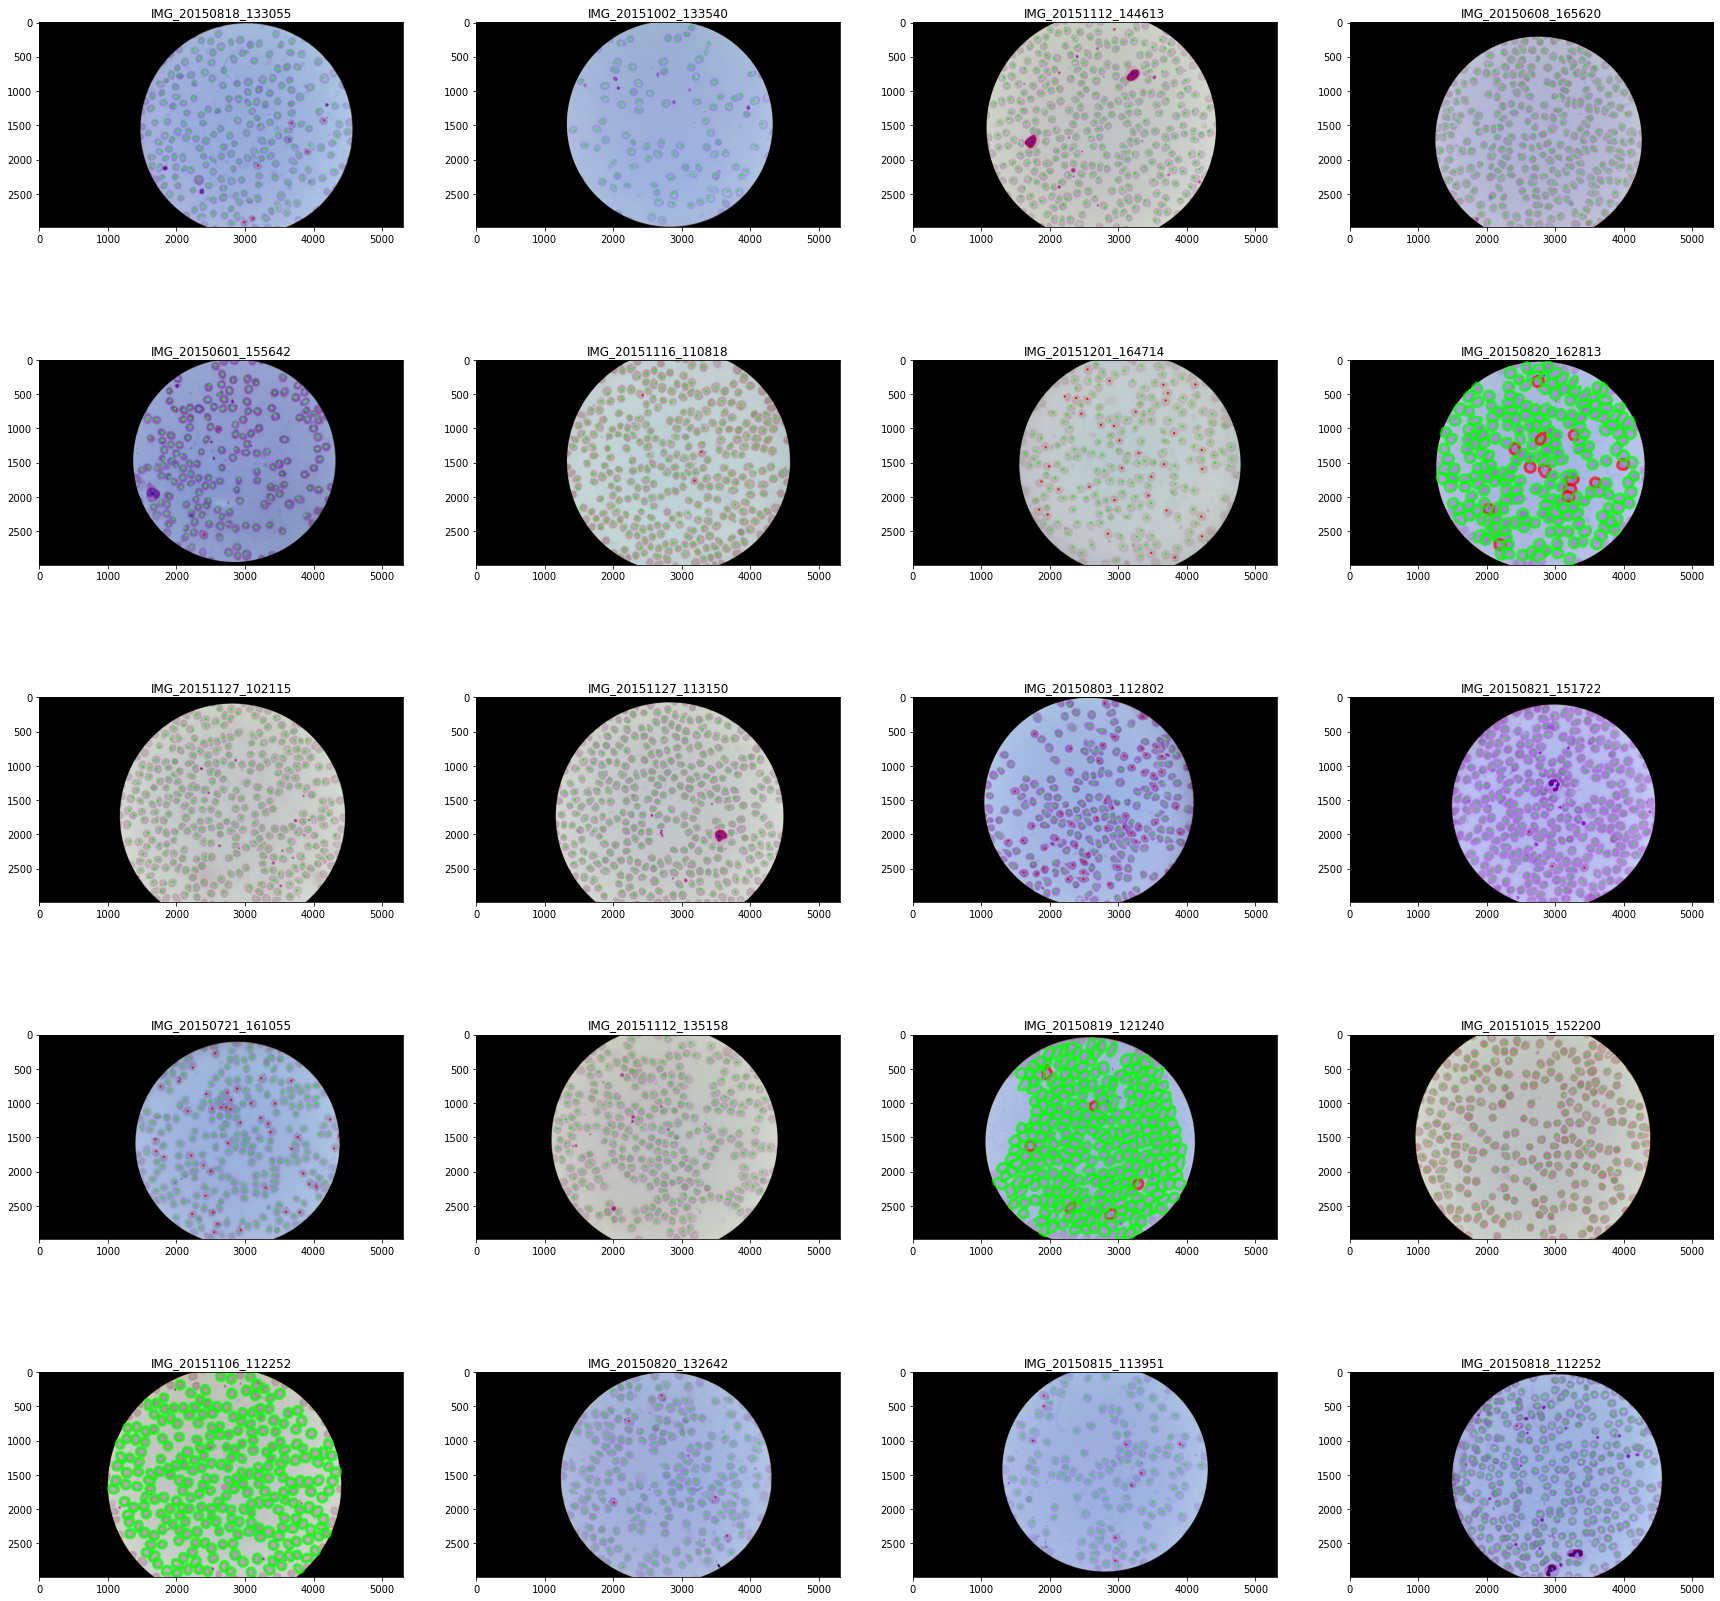

In [205]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'][0], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [210]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [211]:
filename =  'IMG_20150621_112043'

In [212]:
# for filename in df['filename'].unique():
#     df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'positions'].apply(lambda x: )

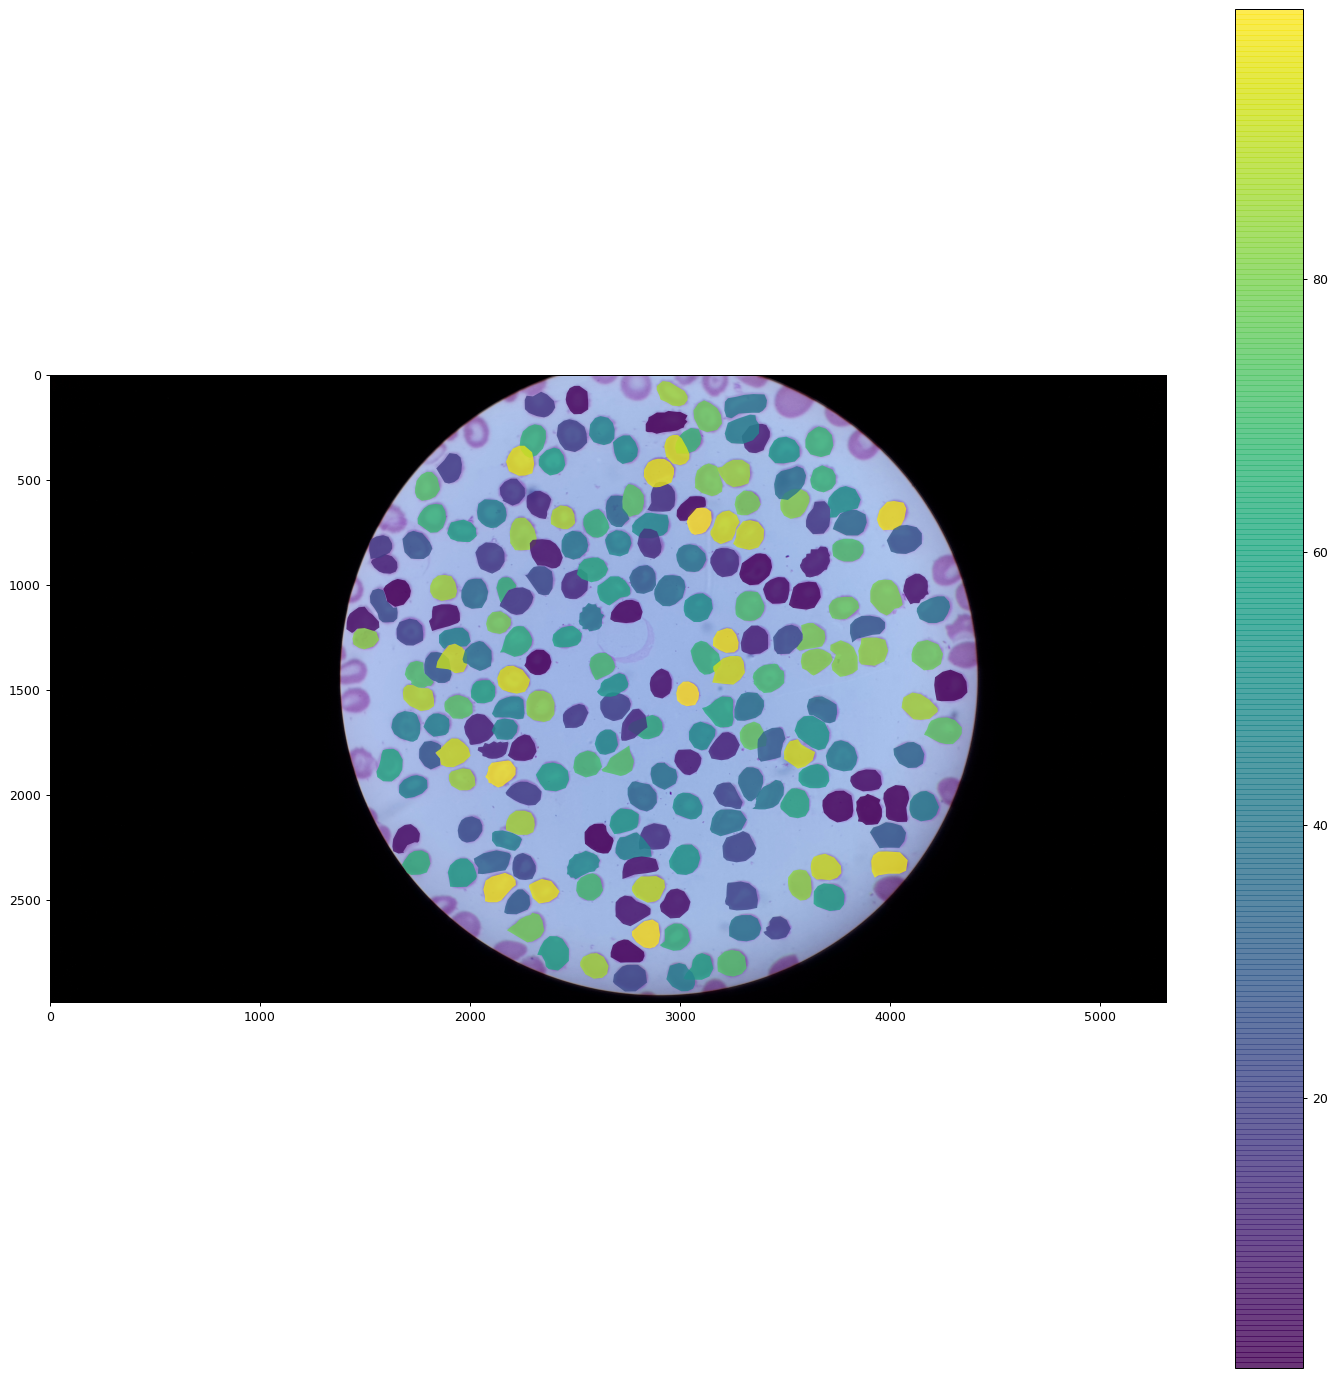

In [217]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)

empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
# [ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'position']]
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)


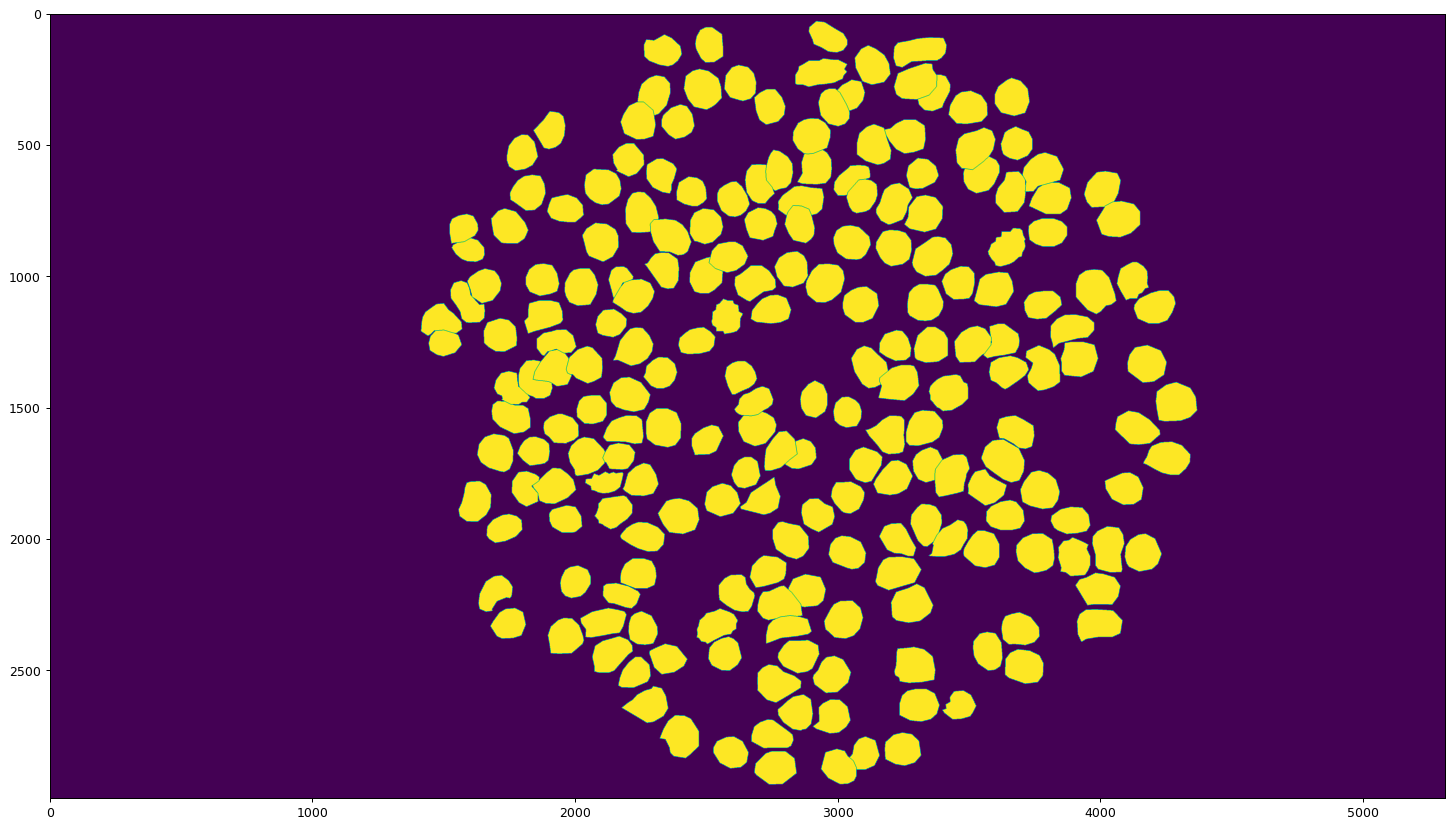

In [224]:

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.flip(img, 1)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

plt.imshow(mask)


In [225]:
ix = random.randint(0, len(train_ids))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()

NameError: name 'train_ids' is not defined